# Using the Rachford Rice equation to find $\beta_v$, $\beta_l$, $\overrightarrow{x_v}$, and $\overrightarrow{x_l}$ from P, T and $\overrightarrow{z}$

First, lets import some packages we will use 

In [24]:
import pandas as pd #to use our data table
import numpy as np #for math operations and arrays
import matplotlib.pyplot as plt #to plot the RR equation

Then, we can import a csv form of figure 6.6-1 from Sandler's Thermodynamics 5th Edition

In [25]:
df = pd.read_csv("sandler6.6-1.csv")
df.head() #we can see what it looks like

,Substance,Symbol,MW,Tc,Pc,Vc,Zc,w,Tboil
0,Acetylene,C2H2,26.038,308.3,6.140,0.1130,0.271,0.184,189.2
1,Ammonia,NH3,17.031,405.6,11.280,0.0724,0.242,0.250,239.7
2,Argon,Ar,39.948,150.8,4.874,0.0749,0.291,-0.004,87.3
3,Benzene,C6H6,78.114,562.1,4.894,0.2590,0.271,0.212,353.3
4,n-Butane,C4H10,58.124,425.2,3.800,0.2550,0.274,0.193,272.7


The values below can be edited (and should be), to match different compositions

- T stands for system temperature, and is assumed to be in degrees farenheit
- P stands for system pressure, and is assumed to be in psia
- list_of_comp is the list of components in the system, and should match a Substance in figure 6.6-1
- zvector are the values of $\overrightarrow{z}$ in the same order as list_of_comp

using different units is possible, however these are the ones mainly used in class

In [26]:
T = 150
P = 200
list_of_comp = ["Propane","n-Butane","n-Octane"]
zvector = [.7,.23,.07]

T+=459.67 #converting to rankine, an absolute unit

Next, we will define some functions: <br /><br />
- ki is our function for Wilson's correlation, and will be used to find the k values of each component, following this equation: <br /><br />
$k_i$ = ($\frac{P_{ci}}{P}$)exp(5.37(1+ $\omega_i$)($\frac{T_{ci}}{T}$)) <br /><br />
- kvector will return a list that will essentially be $\overrightarrow{k}$<br /><br />
- fbv is the Rachford Rice equation:<br /><br />
f($\beta_v$) = $\sum_{i=1}^{Nc}$ $\frac{(1-K_i)z_i}{1-(1-k_i)\beta_v}$=0<br /><br />
- window will give us the upper and lower bounds of Michelsen's window, following these equations: <br /><br />
lower = $\frac{1}{1-k_{max}}$, upper = $\frac{1}{1-k_{min}}$ <br /><br />
- bisection will be used to find the roots of the Rachford Rice equation following the bisection method

In [21]:
#wilson's correlation
def ki(temp,p,pc,tc,omega):
    return (pc/p)*(np.exp((5.37*(1+omega)*(1-(tc/temp)))))

def kvector(nc,temp,pressure):
    kv=[]
    for c in nc:
        tc = df.loc[df['Substance'] == c]["Tc"].item() *1.8 #converting table data to rankine
        pc = df.loc[df['Substance'] == c]["Pc"].item()*145 #converting table data to psia
        w = df.loc[df['Substance'] == c]["w"].item()
        kv.append(ki(temp,pressure,pc,tc,w))
    return kv

#rachford rice equation
def fbv(zv,kv,x):
    output = []
    for i in range(len(zv)):
        ki1 = 1-kv[i]
        ki1zi = (1-kv[i])*zv[i]
        output.append(ki1zi/(1-ki1*x))
    return sum(output)

#Michelsen
def window(kv):
    return [1/(1.00000001-max(kv)),1/(1.00000001-min(kv))] #we add 00000001 to avoid division by zero errors

#bisection method
#code from John T. Foster's Numerical Methods and Programming book
def bisection(fbv, a, b, max_iterations=10000, tolerence=1e-6):

    FA = fbv(zvector,kv,a)

    for i in range(max_iterations):

        p = a + (b - a) / 2
        FP = fbv(zvector,kv,p)

        if np.isclose(FP, 0.0) or (b - a) / 2 < tolerence:
            return p

        if np.sign(FA) * np.sign(FP) > 0:
            a = p
            FA = FP
        else:
            b = p

    return
##############



We these functions, we can find $\overrightarrow{k}$, michelsen's window, and the root of the Rachford Rice equation, which will equal $\beta_v$

In [27]:
kv = kvector(list_of_comp,T,P)
mw = window(kv)
bv = bisection(fbv,mw[0]+.01,mw[1]-.01) 
#if we started the method above directly on the michelsen window, it would return one of the bounds
# therefore we go .1 inward

Here is a graphical representation:

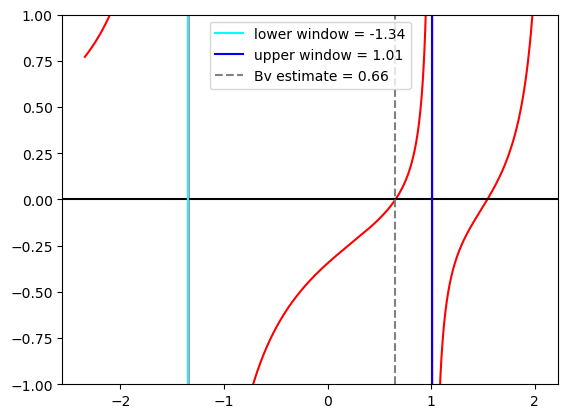

In [23]:
x = np.linspace(-1+mw[0],1+mw[1],1000)
plt.plot(x,fbv(zvector,kv,x),c="red")
plt.ylim([-1,1])
plt.axhline(0,color="black")
plt.axvline(mw[0],label="lower window = {:.2f}".format(mw[0]),color="cyan")
plt.axvline(mw[1],label="upper window = {:.2f}".format(mw[1]),color="blue")
plt.axvline(bv,color="grey",linestyle="--",label="Bv estimate = {:.2f}".format(bv))
plt.legend()

Now we can solve for $\beta_l$, $\overrightarrow{x_l}$, and $\overrightarrow{x_v}$ from these equations: <br /> <br />
$\beta_l$ = 1 -$\beta_v$,   $x_{il}$ = $\frac{z_i}{1-(1-k_i)\beta_v}$,   $x_{iv}$ = $k_i x_{il}$

In [29]:
bl=1-bv
xil=[]
for i in range(len(zvector)):
    xil.append(zvector[i]/(1-(1-kv[i])*bv))
xiv=[]
for i in range(len(zvector)):
    xiv.append(kv[i]*xil[i])

And finally, we can print them

In [34]:
print("The vapor phase fraction is {:.2f}".format(bv))
print("The liquid phase fraction is {:.2f}".format(bl))
print("The liquid phase composition is:")
for i in range(len(xil)):
    print("{:.2f}".format(xil[i]))
print("The vapor phase composition is:")
for i in range(len(xiv)):
    print("{:.2f}".format(xiv[i]))

The vapor phase fraction is 0.66
The liquid phase fraction is 0.34
The liquid phase composition is:
0.47
0.33
0.20
The vapor phase composition is:
0.82
0.18
0.00


Code by Naoufal Ennadi